In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

In [3]:
# Plot images side by side 
def plot_images(image1_title, image1, image2_title, image2, cmap1=None, cmap2="gray"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image1, cmap=cmap1)
    ax1.set_title(image1_title, fontsize=40)

    ax2.imshow(image2, cmap=cmap2)
    ax2.set_title(image2_title, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()


In [4]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of all fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients of all iternations
        self.all_fits = []  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the center of the lane
        self.line_base_pos = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        


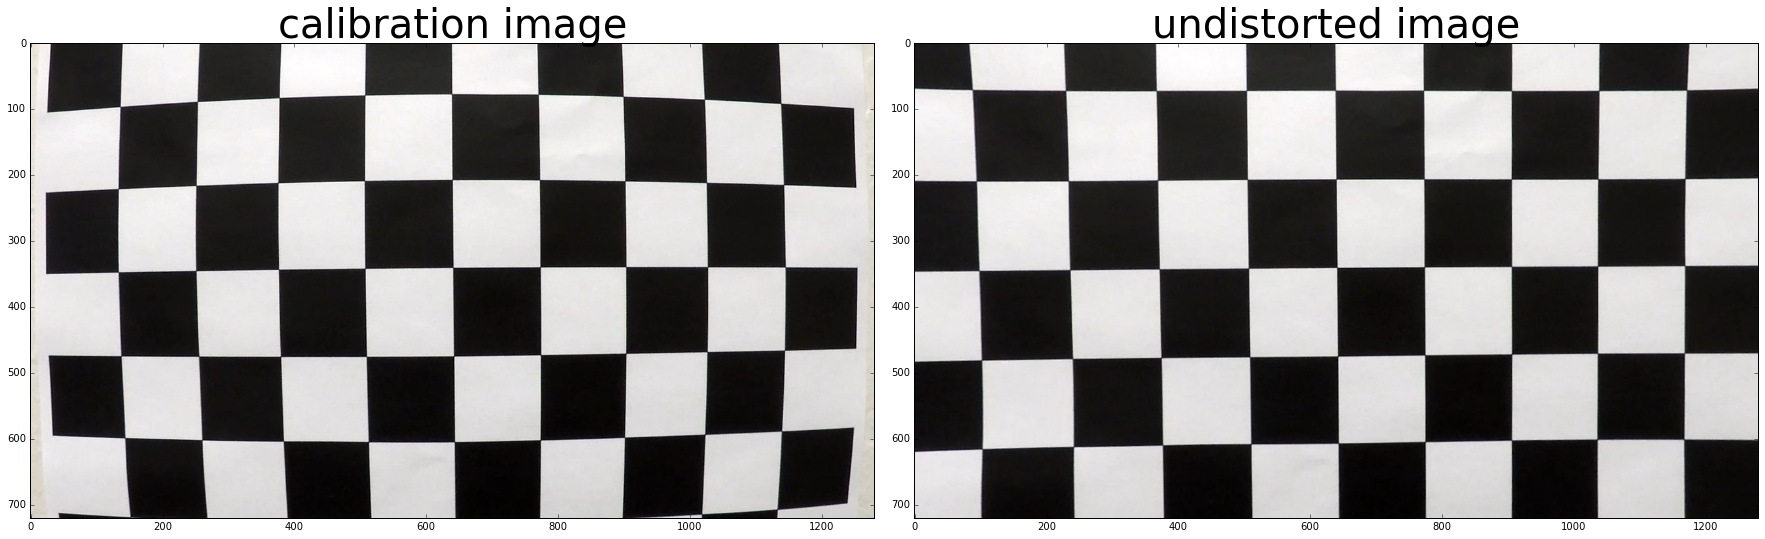

In [5]:
#camera calibration
nx = 9   
ny = 6

objpoints = []
imgpoints = []

# prepare object point [0,0,0], [1,0,0], [2,0,0]...[8,5,0]
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# loop through the calibration images to find the objpoints and imgpoints
images = glob.glob("camera_cal/calibration*.jpg")
for filename in images:
    img = mpimg.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # only include those that meet the nx, ny requirement 
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

    '''
    # draw chessboard corners 
    img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.show()
    '''

# find parameters to calibrate the camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

img = mpimg.imread("camera_cal/calibration1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
undist = cv2.undistort(img, mtx, dist, None, mtx)
plot_images("calibration image", img, "undistorted image", undist, None, None)





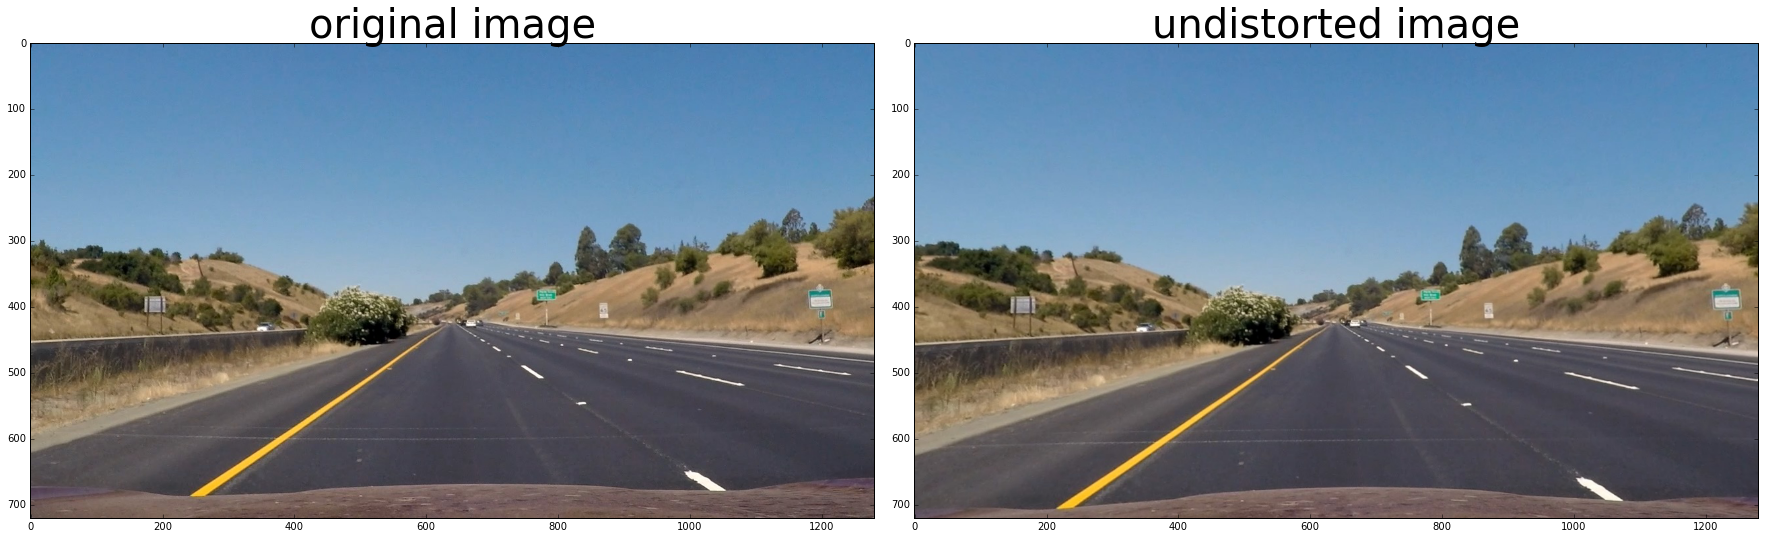

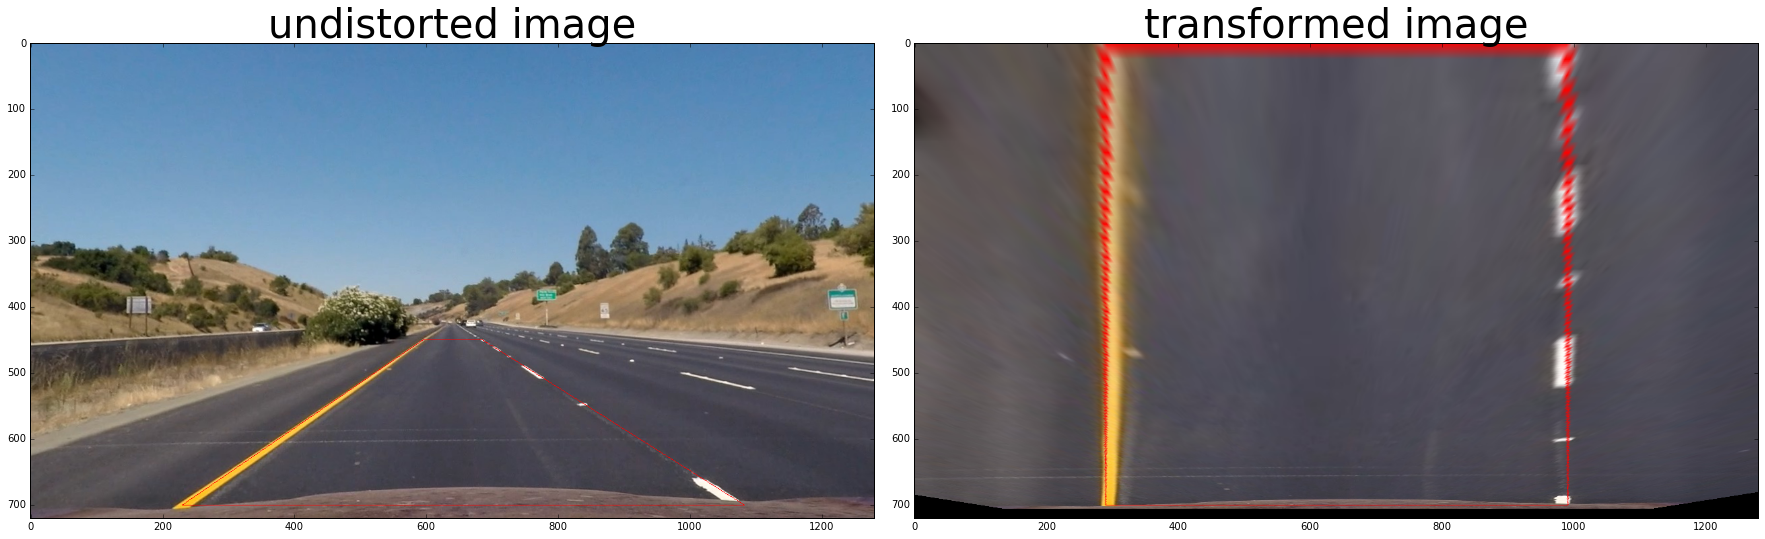

In [6]:
# find the perspective transformation matrix
img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)

plot_images("original image", img, "undistorted image", undist, None, None)


s1 = (230, 700)
s2 = (595, 450)
s3 = (685, 450)
s4 = (1082, 700)

transformed_lane_width = 700

d1 = ((img.shape[1] - transformed_lane_width)/2, 700)
d2 = ((img.shape[1] - transformed_lane_width)/2, 0)
d3 = ((img.shape[1] + transformed_lane_width)/2, 0)
d4 = ((img.shape[1] + transformed_lane_width)/2, 700)

'''
d1 = (290, 700)
d2 = (290, 0)
d3 = (990, 0)
d4 = (990, 700)
'''
src = np.array([s1, s2, s3, s4], np.float32)
dst = np.array([d1, d2, d3, d4], np.float32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)


# test the warped image to see if the transformation is good
cv2.line(undist,s1,s2,(255,0,0),1)
cv2.line(undist,s2,s3,(255,0,0),1)
cv2.line(undist,s3,s4,(255,0,0),1)
cv2.line(undist,s4,s1,(255,0,0),1)

warped = cv2.warpPerspective(undist, M, (undist.shape[1],undist.shape[0]), flags=cv2.INTER_LINEAR)
plot_images("undistorted image", undist, "transformed image", warped, None, None)


In [7]:
# create a thresholded binary image based on the saturation channel
def s_channel_thresh(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2]
    saturation_binary = np.zeros_like(saturation)
    saturation_binary[(saturation > thresh[0]) & (saturation <= thresh[1])] = 1
    return saturation_binary

# create a thresholded binary image based on absolute sobel gradient 
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# create a thresholded binary image based on sobel gradient magnitude
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobel = np.sqrt(sobelx * sobelx + sobely * sobely)
    scaled_sobel = 255*sobel/np.max(sobel)
    
    mag_binary = np.zeros_like(sobel)
    mag_binary[(scaled_sobel > mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

# create a thresholded binary image based on sobel gradient direction
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    gradient = np.arctan2(np.abs(sobely), np.abs(sobelx))
  
    dir_binary = np.zeros_like(gradient)
    dir_binary[(gradient > thresh[0]) & (gradient <= thresh[1])] = 1
    return dir_binary

In [8]:
# Piple line to create a thresholded image based on color and gradient
def pipeline(image):
    ksize = 3
    
    image = np.copy(image)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # convert image to gray scale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY) 
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    
    # get the red and satuation channel binary
    s_channel_binary = s_channel_thresh(undist, thresh=(150, 255))        
    
    '''
    plot_images("l_channel", cv2.warpPerspective(l_channel, M, (s_channel_binary.shape[1], s_channel_binary.shape[0]), flags=cv2.INTER_LINEAR),
                "s_channel", cv2.warpPerspective(s_channel, M, (s_channel_binary.shape[1], s_channel_binary.shape[0]), flags=cv2.INTER_LINEAR),
                "gray", "gray")
    '''
    
    # get the gradient_x and gradient_y binary
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    
    # get the magnitude and direction binary
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(40, 100))
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=(0.7, 1.2))

    '''
    plot_images("mag_binary", cv2.warpPerspective(mag_binary, M, (mag_binary.shape[1], mag_binary.shape[0]), flags=cv2.INTER_LINEAR),
                "dir_binary", cv2.warpPerspective(dir_binary, M, (dir_binary.shape[1], dir_binary.shape[0]), flags=cv2.INTER_LINEAR),
                "gray", "gray")
    '''
    # get the warped image 
    combined_gradient_binary = np.zeros_like(dir_binary)
    combined_gradient_binary[(gradx == 1) & (grady == 1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    #combined_gradient_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    '''
    plot_images("combined_color", cv2.warpPerspective(combined_color_binary, M, (mag_binary.shape[1], mag_binary.shape[0]), flags=cv2.INTER_LINEAR),
                "combined_gradient_binary", cv2.warpPerspective(combined_gradient_binary, M, (dir_binary.shape[1], dir_binary.shape[0]), flags=cv2.INTER_LINEAR),
                "gray", "gray")
    '''
    combined_binary = np.zeros_like(s_channel_binary)
    combined_binary[(s_channel_binary == 1) | (combined_gradient_binary == 1)] = 1
    
    # remove the pixels from 700 to 720 because that is the front of the car
    combined_binary[700:,:] = 0
    
    warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
    
    #plot_images("undistorted image", undist, "thresholded binary", combined_binary, None, "gray") 
    
    return undist, warped

In [9]:
# Step by step search of the lane lines
def blind_search_lane_line(binary_warped, left_lane, right_lane):

    # add back the pixels from 700 to 720 
    if (left_lane.bestx != None) and (right_lane.bestx != None):
        binary_warped[700:,left_lane.bestx-5:left_lane.bestx+5] = 1
        binary_warped[700:,right_lane.bestx-5:right_lane.bestx+5] = 1
       
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

   
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Find distance in meters of vehicle center from the center of the lane
    left_lane.line_base_pos = (leftx_base + rightx_base - 1280)/2 * 3.7/700
    right_lane.line_base_pos = (leftx_base + rightx_base - 1280)/2 * 3.7/700

    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        '''
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        '''
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))        

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    left_lane.allx = nonzerox[left_lane_inds]
    left_lane.ally = nonzeroy[left_lane_inds] 
    right_lane.allx = nonzerox[right_lane_inds]
    right_lane.ally = nonzeroy[right_lane_inds]     
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_lane.ally, left_lane.allx, 2)
    right_fit = np.polyfit(right_lane.ally, right_lane.allx, 2)    
    
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    '''

In [10]:
# Search lane lines started with the averaged lane lines detected in the last 5 iterations
def fast_search_lane_line(binary_warped, left_lane, right_lane):
    
    # add back the pixels from 700 to 720
    if (left_lane.bestx != None) and (right_lane.bestx != None):
        binary_warped[700:,left_lane.bestx:left_lane.bestx+10] = 1
        binary_warped[700:,right_lane.bestx:right_lane.bestx+10] = 1

    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    if (left_lane.best_fit != None) & (right_lane.best_fit != None):
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
    else:
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    left_lane.allx = nonzerox[left_lane_inds]
    left_lane.ally = nonzeroy[left_lane_inds] 
    right_lane.allx = nonzerox[right_lane_inds]
    right_lane.ally = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_lane.ally, left_lane.allx, 2)
    right_fit = np.polyfit(right_lane.ally, right_lane.allx, 2)
    
    # Find the line base position
    y = 720
    leftx_base = left_fit[0]*(y**2) + left_fit[1]*y + left_fit[2]
    rightx_base = right_fit[0]*(y**2) + right_fit[1]*y + right_fit[2]
    
    # Find distance in meters of vehicle center from the center of the lane
    left_lane.line_base_pos = (leftx_base + rightx_base - 1280)/2 * 3.7/700
    right_lane.line_base_pos = (leftx_base + rightx_base - 1280)/2 * 3.7/700

    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    '''
    
    #save the current fit
    left_lane.current_fit = left_fit
    right_lane.current_fit = right_fit
    

In [11]:
# Find the road curvature based on the detected points from blind_search_lane_lines or fast_search_lane_lines
def road_curvature(left_lane, right_lane):

    # all the detected points 
    leftx = left_lane.allx
    lefty = left_lane.ally
    rightx = right_lane.allx
    righty = right_lane.ally
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix+left_lane.line_base_pos, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix-right_lane.line_base_pos, 2)
    
    y_eval = 720
    # Calculate the new radii of curvature
    left_lane.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_lane.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    # print(left_lane.radius_of_curvature, 'm', right_lane.radius_of_curvature, 'm')    
    # Example values: 632.1 m    626.2 m

In [12]:
# Find the road curvature based on the average lane lines from the last 5 iterations 
def road_curvature_best_fit(left_lane, right_lane):

    if (left_lane.best_fit != None) & (right_lane.best_fit != None):
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
    else:
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
    
    # generate the leftx and rightx from the average lane lines from the last 5 iterations 
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #print("line_base_pos", left_lane.line_base_pos, right_lane.line_base_pos)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix+left_lane.line_base_pos, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix-right_lane.line_base_pos, 2)
    
    y_eval = np.max(ploty)
    # Calculate the new radii of curvature
    left_lane.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_lane.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    # print(left_lane.radius_of_curvature, 'm', right_lane.radius_of_curvature, 'm')    
    # Example values: 632.1 m    626.2 m

In [13]:
# sanity check whether the detected lane lines make sense
def sanity_check(left_lane, right_lane):
        
    # check curvature
    if (np.min([left_lane.radius_of_curvature, right_lane.radius_of_curvature]) < 700) & \
        (np.abs(left_lane.radius_of_curvature - right_lane.radius_of_curvature) > 300):
        return False
    
    # use the fit from current detection 
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    # check the horizontal distance 
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    dist = abs(left_fitx - right_fitx)
    #print(np.max(dist), np.min(dist))
    if (np.max(dist) - np.min(dist)) > 100:
        return False
    
    # add the left_fitx at 700 to the recent_fitx
    left_lane.recent_xfitted.append(left_fitx[700])
    right_lane.recent_xfitted.append(right_fitx[700])
    
    # find the best x position at 700
    left_lane.bestx = np.average(left_lane.recent_xfitted[-5:])
    right_lane.bestx = np.average(right_lane.recent_xfitted[-5:])
    
    # add the fits to the list
    left_lane.all_fits.append(left_lane.current_fit)
    right_lane.all_fits.append(right_lane.current_fit)
     
    # find the best fits over the last 5 iterations  
    left_lane.best_fit = np.average(left_lane.all_fits[-5:], axis=0)
    right_lane.best_fit = np.average(right_lane.all_fits[-5:], axis=0)
        
    return True

In [18]:
# draw road back to the source image 
def draw_road(undist_img, binary_warped, left_lane, right_lane):
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if (left_lane.best_fit != None) & (right_lane.best_fit != None):
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
    else:
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
        
    # calculate the leftx and rightx based on the left polynomial and the right polynomial
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    # find the road_curvature based on the best fit lane line
    road_curvature_best_fit(left_lane, right_lane)
    
    # output the curvature of the lane
    cv2.putText(result,"Radius of Curvature = {0:.0f}(m)".format(
                np.average([left_lane.radius_of_curvature, right_lane.radius_of_curvature])), 
                (50, 75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)

    # output the distance of the car from the center of the lane
    if (left_lane.line_base_pos > 0):
        cv2.putText(result,"Vehicle is {0:.2f}m left of center".format((left_lane.line_base_pos)), 
                (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    else:
        cv2.putText(result,"Vehicle is {0:.2f}m right of center".format((-left_lane.line_base_pos)), 
                (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        
    return result

In [20]:
# generate the lane boundaries on the image
def process_image(image):

    global first_time
    
    # get the undistored image and thresholded binary image from the pipeline
    undist, binary_warped = pipeline(image)
 
    # if it is the first image, use the blind_search_lane_line method to find the lane lines
    # otherwise, use the fast_search_lane_line method
    if first_time:
        blind_search_lane_line(binary_warped, left_lane, right_lane)
        first_time = False
    else:
        fast_search_lane_line(binary_warped, left_lane, right_lane)
        
    road_curvature(left_lane, right_lane)
    
    # if sanity check failed and the lane lines were detected in the last frame, use the best fit for boundaries
    # otherwise, do the blind_search_lane_line method again. 
    if sanity_check(left_lane, right_lane) == False:
        #print("1st sanity check failed")
        if (left_lane.detected == False) & (right_lane.detected == False): 
            blind_search_lane_line(binary_warped, left_lane, right_lane)
            road_curvature(left_lane, right_lane)
            
            if sanity_check(left_lane, right_lane) == False:
                #print("2nd sanity check failed")
                left_lane.detected = False
                right_lane.detected = False
            else:
                #print("2nd sanity check succeeded")
                left_lane.detected = True
                right_lane.detected = True
        else:
            #print("use last coordinates")
            left_lane.detected = False
            right_lane.detected = False
    else:            
        #print("1st sanity check succeeded")
        left_lane.detected = True
        right_lane.detected = True
        
    
    #warped = cv2.warpPerspective(undist, M, (undist.shape[1], undist.shape[0]), flags=cv2.INTER_LINEAR)
    #plot_images("warped", warped, "binary_warped", binary_warped, "gray", "gray")
    
    return draw_road(undist, binary_warped, left_lane, right_lane)

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

first_time = True
left_lane = Line()
right_lane = Line()

output_file = 'project_video_with_lane.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(process_image) 
%time output_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_with_lane.mp4
[MoviePy] Writing video project_video_with_lane.mp4


100%|█████████▉| 1260/1261 [05:01<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_with_lane.mp4 

CPU times: user 18min 21s, sys: 1min 51s, total: 20min 13s
Wall time: 5min 2s
